In [3]:
# Google Driveと接続を行います。これを行うことで、Driveにあるデータにアクセスできるようになります。
# 下記セルを実行すると、Googleアカウントのログインを求められますのでログインしてください。
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
# 作業フォルダへの移動を行います。
# 人によって作業場所がことなるので、その場合作業場所を変更してください。
import os 
os.chdir('/content/drive/MyDrive/100knock-data_analytics/6章') #ここを変更。

# 6章 物流の最適ルートをコンサルティングする１０本ノック

ここでは、「物流」の基礎となる「輸送最適化」を検討するにあたっての基礎的な技術を習得します。  
実際の物流データからネットワーク構造を可視化する方法について学び、最適な物流計画を立案する流れを学んでいきます。

### ノック５１：物流に関するデータを読み込んでみよう

In [1]:
import pandas as pd

factories = pd.read_csv('tbl_factory.csv', index_col=0)
factories

,FCName,FCDemand,FCRegion
FCID,,,
FC00001,東京工場,28,関東
FC00002,木更津工場,29,関東
FC00003,多摩工場,31,関東
FC00004,横須賀工場,25,関東
FC00005,仙台工場,21,東北
FC00006,山形工場,30,東北
FC00007,那須工場,25,東北
FC00008,青森工場,16,東北


In [2]:
warehouse = pd.read_csv('tbl_warehouse.csv', index_col=0)
warehouse

,WHName,WHSupply,WHRegion
WHID,,,
WH00001,杉並倉庫,35,関東
WH00002,品川倉庫,41,関東
WH00003,豊洲倉庫,42,関東
WH00004,郡山倉庫,60,東北
WH00005,仙台倉庫,72,東北
WH00006,山形倉庫,65,東北


In [3]:
cost = pd.read_csv('rel_cost.csv', index_col=0)
cost.head()

,FCID,WHID,Cost
RCostID,,,
1,FC00001,WH00001,0.4
2,FC00001,WH00002,0.8
3,FC00001,WH00003,1.5
4,FC00002,WH00001,0.9
5,FC00002,WH00002,0.8


In [4]:
trans = pd.read_csv('tbl_transaction.csv', index_col=0)
trans.head()

,TransactionDate,ToFC,FromWH,Quantity
TRID,,,,
0,2019-01-01 02:11:10,FC00004,WH00003,33
1,2019-01-01 06:12:42,FC00007,WH00006,19
2,2019-01-01 06:32:32,FC00006,WH00004,31
3,2019-01-01 07:17:06,FC00002,WH00003,18
4,2019-01-01 07:52:18,FC00001,WH00002,30


In [5]:
join_data = pd.merge(trans, cost, left_on=['ToFC', 'FromWH'], right_on=['FCID', 'WHID'], how='left')
join_data.head()

,TransactionDate,ToFC,FromWH,Quantity,FCID,WHID,Cost
0,2019-01-01 02:11:10,FC00004,WH00003,33,FC00004,WH00003,1.1
1,2019-01-01 06:12:42,FC00007,WH00006,19,FC00007,WH00006,1.3
2,2019-01-01 06:32:32,FC00006,WH00004,31,FC00006,WH00004,0.9
3,2019-01-01 07:17:06,FC00002,WH00003,18,FC00002,WH00003,1.6
4,2019-01-01 07:52:18,FC00001,WH00002,30,FC00001,WH00002,0.8


In [6]:
join_data = pd.merge(join_data, factories, left_on='ToFC', right_on='FCID', how='left')
join_data.head()

,TransactionDate,ToFC,FromWH,Quantity,FCID,WHID,Cost,FCName,FCDemand,FCRegion
0,2019-01-01 02:11:10,FC00004,WH00003,33,FC00004,WH00003,1.1,横須賀工場,25,関東
1,2019-01-01 06:12:42,FC00007,WH00006,19,FC00007,WH00006,1.3,那須工場,25,東北
2,2019-01-01 06:32:32,FC00006,WH00004,31,FC00006,WH00004,0.9,山形工場,30,東北
3,2019-01-01 07:17:06,FC00002,WH00003,18,FC00002,WH00003,1.6,木更津工場,29,関東
4,2019-01-01 07:52:18,FC00001,WH00002,30,FC00001,WH00002,0.8,東京工場,28,関東


In [10]:
join_data = pd.merge(join_data, warehouse, left_on='FromWH', right_on='WHID', how='left', suffixes=('_left', '_right'))
join_data = join_data[['TransactionDate', 'Quantity', 'Cost', 'ToFC', 'FCName', 'FCDemand', 'FromWH', 'WHName', 'WHSupply', 'WHRegion']]
join_data.head()

,TransactionDate,Quantity,Cost,ToFC,FCName,FCDemand,FromWH,WHName,WHSupply,WHRegion
0,2019-01-01 02:11:10,33,1.1,FC00004,横須賀工場,25,WH00003,豊洲倉庫,42,関東
1,2019-01-01 06:12:42,19,1.3,FC00007,那須工場,25,WH00006,山形倉庫,65,東北
2,2019-01-01 06:32:32,31,0.9,FC00006,山形工場,30,WH00004,郡山倉庫,60,東北
3,2019-01-01 07:17:06,18,1.6,FC00002,木更津工場,29,WH00003,豊洲倉庫,42,関東
4,2019-01-01 07:52:18,30,0.8,FC00001,東京工場,28,WH00002,品川倉庫,41,関東


In [11]:
kanto = join_data.loc[join_data['WHRegion']=='関東']
kanto.head()

,TransactionDate,Quantity,Cost,ToFC,FCName,FCDemand,FromWH,WHName,WHSupply,WHRegion
0,2019-01-01 02:11:10,33,1.1,FC00004,横須賀工場,25,WH00003,豊洲倉庫,42,関東
3,2019-01-01 07:17:06,18,1.6,FC00002,木更津工場,29,WH00003,豊洲倉庫,42,関東
4,2019-01-01 07:52:18,30,0.8,FC00001,東京工場,28,WH00002,品川倉庫,41,関東
7,2019-01-01 09:09:30,12,1.5,FC00001,東京工場,28,WH00003,豊洲倉庫,42,関東
8,2019-01-01 10:52:55,27,1.5,FC00003,多摩工場,31,WH00003,豊洲倉庫,42,関東


In [12]:
tohoku = join_data.loc[join_data['WHRegion']=='東北']
tohoku.head()

,TransactionDate,Quantity,Cost,ToFC,FCName,FCDemand,FromWH,WHName,WHSupply,WHRegion
1,2019-01-01 06:12:42,19,1.3,FC00007,那須工場,25,WH00006,山形倉庫,65,東北
2,2019-01-01 06:32:32,31,0.9,FC00006,山形工場,30,WH00004,郡山倉庫,60,東北
5,2019-01-01 08:56:09,31,0.3,FC00005,仙台工場,21,WH00005,仙台倉庫,72,東北
6,2019-01-01 09:00:15,33,0.7,FC00006,山形工場,30,WH00006,山形倉庫,65,東北
9,2019-01-01 14:12:51,21,0.7,FC00006,山形工場,30,WH00006,山形倉庫,65,東北


### ノック５２：現状の輸送量、コストを確認してみよう

In [15]:
print('関東支社の総コスト：' + str(kanto['Cost'].sum()) + '万円')
print('東北支社の総コスト：' + str(tohoku['Cost'].sum()) + '万円')

関東支社の総コスト：2189.3万円
東北支社の総コスト：2062.0万円


In [17]:
print('関東支社の総部品輸送個数：' + str(kanto['Quantity'].sum()) + '個')
print('東北支社の総部品輸送個数：' + str(tohoku['Quantity'].sum()) + '個')

関東支社の総部品輸送個数：49146個
東北支社の総部品輸送個数：50214個


In [18]:
# 部品一つあたりの輸送コスト
tmp = (kanto['Cost'].sum() / kanto['Quantity'].sum()) * 10000
print('関東支社１つあたりの輸送コスト：' + str(int(tmp)) + '円')

tmp = (tohoku['Cost'].sum() / tohoku['Quantity'].sum()) * 10000
print('東北支社１つあたりの輸送コスト：' + str(int(tmp)) + '円')

関東支社１つあたりの輸送コスト：445円
東北支社１つあたりの輸送コスト：410円


In [20]:
# コストテーブルを支社ごとに集計
cost_chk = pd.merge(cost, factories, on='FCID', how='left')

# 平均
print('東京支社の平均輸送コスト：' + str(cost_chk['Cost'].loc[cost_chk['FCRegion']=='関東'].mean()) + '万円')
print('東北支社の平均輸送コスト：' + str(cost_chk['Cost'].loc[cost_chk['FCRegion']=='東北'].mean()) + '万円')

東京支社の平均輸送コスト：1.075万円
東北支社の平均輸送コスト：1.05万円


### ノック５３：ネットワークを可視化してみよう

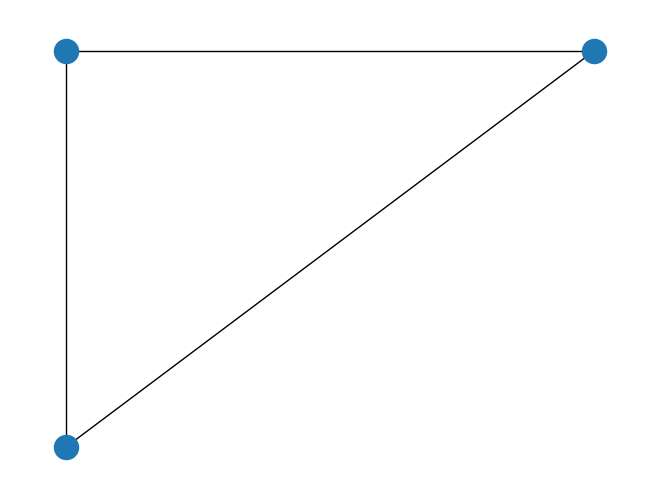

In [21]:
import networkx as nx
import matplotlib.pyplot as plt

# グラフオブジェクトの作成
G = nx.Graph()

# 頂点の設定
G.add_node('nodeA')
G.add_node('nodeB')
G.add_node('nodeC')

# 辺の設定
G.add_edge('nodeA', 'nodeB')
G.add_edge('nodeA', 'nodeC')
G.add_edge('nodeB', 'nodeC')

# 座標の設定
pos = {}
pos['nodeA'] = (0, 0)
pos['nodeB'] = (1, 1)
pos['nodeC'] = (0, 1)

# 描画
nx.draw(G, pos)

# 表示
plt.show()

### ノック５４：ネットワークにノードを追加してみよう

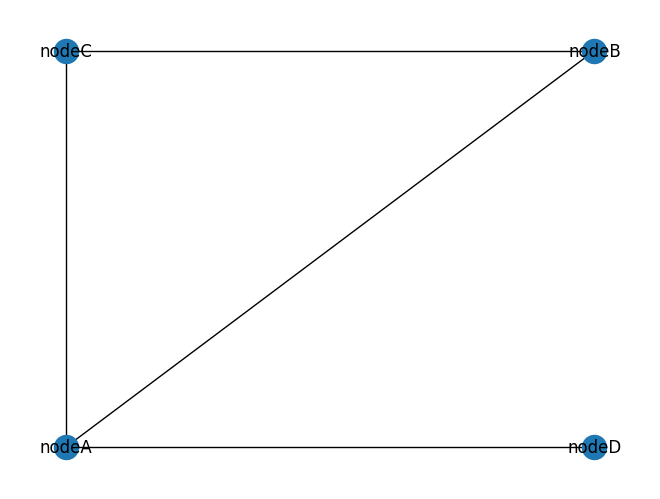

In [22]:
# グラフオブジェクトの作成
G = nx.Graph()

# 頂点の設定
G.add_node('nodeA')
G.add_node('nodeB')
G.add_node('nodeC')
G.add_node('nodeD')


# 辺の設定
G.add_edge('nodeA', 'nodeB')
G.add_edge('nodeA', 'nodeC')
G.add_edge('nodeB', 'nodeC')
G.add_edge('nodeA', 'nodeD')


# 座標の設定
pos = {}
pos['nodeA'] = (0, 0)
pos['nodeB'] = (1, 1)
pos['nodeC'] = (0, 1)
pos['nodeD'] = (1, 0)


# 描画
nx.draw(G, pos, with_labels=True)

# 表示
plt.show()



### ノック５５：ルートの重みづけを実施しよう

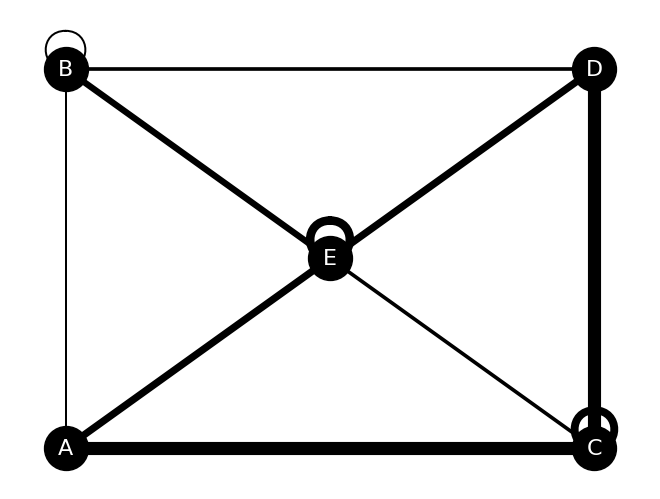

In [36]:
import numpy as np

# データ読み込み
df_w = pd.read_csv('network_weight.csv')
df_p = pd.read_csv('network_pos.csv')

# エッジの重みのリスト化
size = 10
edge_weights = []
for i in range(len(df_w)):
   for j in range(len(df_w.columns)):
       edge_weights.append(df_w.iloc[i][j] * size)
       
# グラフオブジェクトの作成
G = nx.Graph()

# 頂点の設定
for i in range(len(df_w.columns)):
   G.add_node(df_w.columns[i])

# 辺の設定
for i in range(len(df_w.columns)):
   for j in range(len(df_w.columns)):
       G.add_edge(df_w.columns[i], df_w.columns[j])
       
# 座標の設定
pos = {}
for i in range(len(df_w.columns)):
   node = df_w.columns[i]
   pos[node] = [df_p[node][0], df_p[node][1]]
   
# 描画
nx.draw(G, pos, with_labels=True, font_size=16, node_size=1000, node_color='k', font_color='w', width=edge_weights)

# 表示
plt.show()

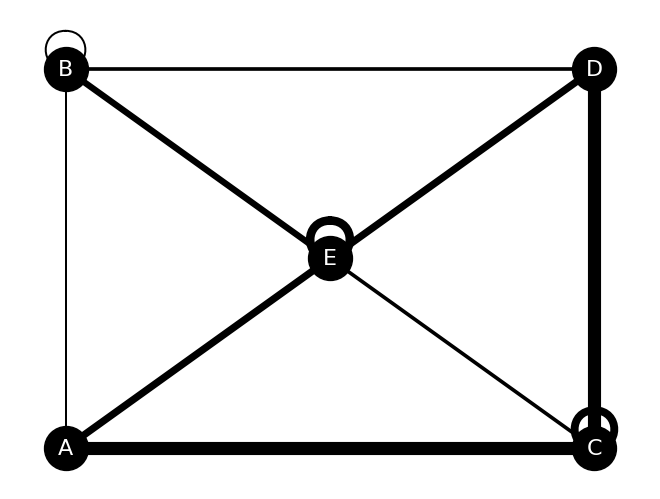

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

#df_wはA～E各頂点同士のリンクの重みが記載された5行×5列のデータです。
df_w=pd.read_csv('network_weight.csv')
#df_pはA～E各頂点のリンクの位置が記載された2行×5列のデータです。
df_p=pd.read_csv('network_pos.csv')


size=10
#edge_weightsというリストを宣言します。
edge_weights=[]
#nodeの重みデータの要素数（5個）分繰り返し処理します。
for i in range(len(df_w)):
  #len(.columns)で列数（横方向の要素数）を取得できます。
  #今回は、列はA～Eまでの5つあります。
  for j in range(len(df_w.columns)):
    #edge_weightsリストにdf_wの全要素に10をかけたものを格納します。
    edge_weights.append(df_w.iloc[i][j]*size)

# グラフオブジェクトの作成を行います。
G=nx.Graph()

#頂点の追加を行います。
#df_wの列（A～Eまでの5つ）数分繰り返し処理します。
for i in range(len(df_w.columns)):
  #df_wテーブルの列の名前をそのまま頂点として追加します。
  G.add_node(df_w.columns[i])

#頂点を結び、辺の追加を行います。
#df_wの列（A～Eまでの5つ）数分繰り返し処理します。
for i in range(len(df_w.columns)):
  #iと同じfor文の繰り返し構造ですが、同じ頂点同士を結ぶことを含め、全頂点を結び、辺の追加を行います。
  for j in range(len(df_w.columns)):
    G.add_edge(df_w.columns[i],df_w.columns[j])

pos={}
#df_wの列（A～Eまでの5つ）数分繰り返し処理します。
for i in range(len(df_w.columns)):
  #df_wの列（A～Eまでの5つ）名をnodeという変数に格納します。
  node=df_w.columns[i]
  #それぞれのnodeに対して、df_pの各行に記載されたデータを座標位置として設定します。
  pos[node]=(df_p[node][0],df_p[node][1])

#draw()メソッドで描画します。
nx.draw(G,pos,with_labels=True,font_size=16,node_size=1000,node_color='k',font_color='w',width=edge_weights)

#show()メソッドを用いて表示します。
plt.show()

### ノック５６：輸送ルート情報を読み込んでみよう

In [38]:
df_tr = pd.read_csv('trans_route.csv', index_col='工場')
df_tr.head()

,F1,F2,F3,F4
工場,,,,
W1,15,15,0,5
W2,5,0,30,5
W3,10,15,2,15


In [40]:
df_pos = pd.read_csv('trans_route_pos.csv')
df_pos.head()

,W1,W2,W3,F1,F2,F3,F4
0,0,0,0,4.0,4.0,4.0,4.0
1,1,2,3,0.5,1.5,2.5,3.5


### ノック５７：輸送ルート情報からネットワークを可視化してみよう

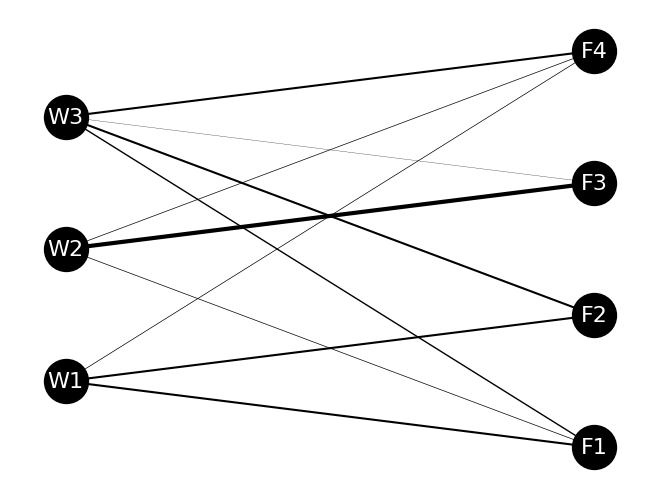

In [39]:
#グラフオブジェクトの作成を行います。
G = nx.Graph()

#add_node(頂点)で頂点の追加を行います。
#len(.columns)でdf_posの列（W1～W3とF1～F4まで）数7回分操作を繰り返します。
for i in range(len(df_pos.columns)):
   G.add_node(df_pos.columns[i])
   
#辺の設定&エッジの重みのリスト化を行います。
num_pre = 0
#edge_weightsという重みを格納するためのリストを宣言します。
edge_weights = []
size = 0.1

#len(.columns)でdf_posの列（W1～W3とF1～F4まで）数7回分操作を繰り返します。
for i in range(len(df_pos.columns)):
 
   #iと同じfor文の繰り返し構造ですが、このfor文にすることで全頂点の重みの追加を行います。
   for j in range(len(df_pos.columns)):
       #if notとすることで、ループ変数が同じ頂点をもつときは操作を行わないようにします。
       if not (i == j):
          
           #頂点を結び、辺の追加を行います。
           G.add_edge(df_pos.columns[i], df_pos.columns[j])
          
           #エッジの重みの追加を行います。
           #1つ上のコードで追加されるedgeに対して、num_preが小さい場合if文の中の操作を行います。
           if num_pre < len(G.edges):
          
               #num_preを追加されたedge数で更新します。
               num_pre = len(G.edges)
               weight = 0
               if (df_pos.columns[i] in df_tr.columns) and (df_pos.columns[j] in df_tr.index):
                   if df_tr[df_pos.columns[i]][df_pos.columns[j]]:
                       weight = df_tr[df_pos.columns[i]][df_pos.colunms[j]] * size
               elif (df_pos.columns[j] in df_tr.columns) and (df_pos.columns[i] in df_tr.index):
                   if df_tr[df_pos.columns[j]][df_pos.columns[i]]:
                       weight = df_tr[df_pos.columns[j]][df_pos.columns[i]] * size
               edge_weights.append(weight)
               
#座標の設定を行います。
pos = {}

#df_posの列（W1～W3とF1～F4まで）数7回分操作を繰り返します。
for i in range(len(df_pos.columns)):
   #df_wの列（W1～W3とF1～F4まで）名をnodeという変数に格納します。
   node = df_pos.columns[i]
   #それぞれのnodeに対して、df_posの各行に記載されたデータを座標位置として設定します。
   pos[node] = (df_pos[node][0], df_pos[node][1])
   
#draw()メソッドで描画します。
nx.draw(G, pos, with_labels=True, font_size=16, node_size = 1000, node_color = 'k', font_color='w', width=edge_weights)

#show()メソッドを用いて表示します。
plt.show()

### ノック５８：輸送コスト関数を作成しよう

In [42]:
# データ読み込み
df_tr = pd.read_csv('trans_route.csv', index_col='工場')
df_tc = pd.read_csv('trans_cost.csv', index_col='工場')

# 輸送コスト関数
def trans_cost(df_tr, df_tc):
    cost = 0
    for i in range(len(df_tc.index)):
        for j in range(len(df_tr.columns)):
            cost += df_tr.iloc[i][j] * df_tc.iloc[i][j]
    return cost

print('輸送コスト：' + str(trans_cost(df_tr, df_tc)))

輸送コスト：1493


### ノック５９：制約条件を作ってみよう

In [46]:
# データの読み込み
df_tr = pd.read_csv('trans_route.csv', index_col='工場')
df_demand = pd.read_csv('demand.csv')
df_supply = pd.read_csv('supply.csv')

# 需要側の制約条件
for i in range(len(df_demand.columns)):
    temp_sum = sum(df_tr[df_demand.columns[i]])
    print(str(df_demand.columns[i]) + 'への輸送料：' + str(temp_sum) + ' (需要量：' + str(df_demand.iloc[0][i]) + ')')

    if temp_sum >= df_demand.iloc[0][i]:
        print('需要量を満たしています。')
    else:
        print('需要量を満たしていません。輸送ルートを再計算して下さい。')

# 供給側の制約条件
for i in range(len(df_supply.columns)):
    temp_sum = sum(df_tr.loc[df_supply.columns[i]])
    print(str(df_supply.columns[i]) + 'への輸送料：' + str(temp_sum) + ' (供給限界：' + str(df_supply.iloc[0][i]) + ')')

    if temp_sum <= df_supply.iloc[0][i]:
        print('供給限界を満たしています。')
    else:
        print('供給限界を超過しています。輸送ルートを再計算して下さい。')


F1への輸送料：30 (需要量：28)
需要量を満たしています。
F2への輸送料：30 (需要量：29)
需要量を満たしています。
F3への輸送料：32 (需要量：31)
需要量を満たしています。
F4への輸送料：25 (需要量：25)
需要量を満たしています。
W1への輸送料：35 (供給限界：35)
供給限界を満たしています。
W2への輸送料：40 (供給限界：41)
供給限界を満たしています。
W3への輸送料：42 (供給限界：42)
供給限界を満たしています。


In [ ]:
import pandas as pd

#trans_route.csvは輸送ルート情報を記載した3行(W1～W3)×4列(F1～F4)のデータです。
df_tr = pd.read_csv('trans_route.csv', index_col='工場')

#demand.csvは工場の製品生産量に対する需要を記載した1行×4列(F1～F4)のデータです。
df_demand = pd.read_csv('demand.csv')

#supply.csvは倉庫が供給可能な部品数の上限を記載した1行×3列(W1～W3)のデータです。
df_supply = pd.read_csv('supply.csv')

#需要側の制約条件を満たすかどうかを審査します。
#len(.columns)でdf_trの列（F1～F4）数4回分操作を繰り返します。
for i in range(len(df_demand.columns)):

   #df_demand.columns[i]はF1～F4を指します。
   #df_tr[df_demand.columns[i]]はdf_tr[F〇]という意味になります。
   #つまり、各工場のW1～W3との輸送ルート情報を抜き出しています。
   #sum()を使用して、各工場ごとのW1～W3の需要の合計を算出し、temp_sumに格納しています。
   temp_sum = sum(df_tr[df_demand.columns[i]])

   #str関数でF1～F4の工場名、各工場ごとのW1～W3の需要の合計、工場の製品生産量に対する需要を文字列型に変換します。
   print(str(df_demand.columns[i]) + 'への輸送量：' + str(temp_sum) + ' (需要量：' + str(df_demand.iloc[0][i])+')')

   #各工場ごとのW1～W3の需要の合計が工場の製品生産量に対する需要より上回る場合、需要側の制約条件を満たすと判断します。
   if temp_sum >= df_demand.iloc[0][i]:
         print('需要量を満たしています。')
   else:
         print('需要量を満たしていません。輸送ルートを再計算してください。')
         
#供給側の制約条件を満たすかどうかを審査します。
#len(.columns)でdf_supplyの列（W1～W3）数3回分操作を繰り返します。
for i in range(len(df_supply.columns)):

   #df_supply.columns[i]はW1～W3を指します。
   #df_tr.loc[df_supply.columns[i]]はdf_tr.loc[W〇]という意味になります。
   #つまり、各倉庫からみたF1～F4との輸送ルート情報を抜き出しています。
   #sum()を使用して、各倉庫からみたF1～F4への供給限界量の合計を算出し、temp_sumに格納しています。
   temp_sum = sum(df_tr.loc[df_supply.columns[i]])

   #str関数でW1～W3の倉庫名、各倉庫からみたF1～F4への供給限界量の合計、倉庫が供給可能な部品数の上限を文字列型に変換します。
   print(str(df_supply.columns[i])+ 'からの輸送量：' + str(temp_sum)+ '(供給限界：' + str(df_supply.iloc[0][i])+')')

   #各倉庫からみたF1～F4への供給限界量の合計が倉庫が供給可能な部品数の上限より下回る場合、供給側の制約条件を満たすと判断します。
   if temp_sum <= df_supply.iloc[0][i]:
       print('供給限界の範囲内です。')
   else:
       print('供給限界を超過しています。輸送ルートを再計算してください。')

### ノック６０：輸送ルートを変更して、輸送コスト関数の変化を確認しよう

In [47]:
#trans_route_new.csvは新しく設計し直された輸送ルート情報を記載した3行(W1～W3)×4列(F1～F4)のデータです。
df_tr_new = pd.read_csv('trans_route_new.csv', index_col='工場')
print(df_tr_new)

#新しく設計し直された輸送ルート情報を用いて総輸送コストを再計算します。
#str関数で再計算結果を文字列型に変換しています。
print('総輸送コスト（変更後)：' + str(trans_cost(df_tr_new, df_tc)))

#defで需要側の制約条件を計算する関数を定義します。
def condition_demand(df_tr, df_demand):

   #df_demand.columnsは4(F1～F4の列数)を指します。
   #np.zeros()は、すべての要素を0とする配列を生成します。
   #len(4)としているので、要素数が4の配列を生成し、flagとしています。
   flag = np.zeros(len(df_demand.columns))

   #len(.columns)でdf_demandの列（F1～F4）数4回分操作を繰り返します。
   for i in range(len(df_demand.columns)):

       #df_tr[df_demand.columns[i]]はdf_tr[F〇]という意味になります。
       #つまり、各工場のW1～W3との輸送ルート情報を抜き出しています。
       #sum()を使用して、各工場ごとのW1～W3の需要の合計を算出し、temp_sumに格納しています。
       temp_sum = sum(df_tr[df_demand.columns[i]])

       #各工場ごとのW1～W3の需要の合計が工場の製品生産量に対する需要より上回る場合、需要側の制約条件を満たすと判断します。
       if (temp_sum >= df_demand.iloc[0][i]):
           #制約条件を満たすとき、flag配列の要素を0から1と変換します。
           flag[i] = 1
   return flag

#defで供給側の制約条件を計算する関数を定義します。
def condition_supply(df_tr, df_supply):
 
  #df_supply.columnsは3(W1～W3の列数)を指します。
   #len(3)としているので、要素数が3の配列を生成し、flagとしています。
   flag = np.zeros(len(df_supply.columns))

   #len(.columns)でdf_supplyの列（W1～W3）数3回分操作を繰り返します。
   for i in range(len(df_supply.columns)):

       #df_supply.columns[i]はW1～W3を指します。
       #df_tr.loc[df_supply.columns[i]]はdf_tr.loc[W〇]という意味になります。
       #つまり、各倉庫からみたF1～F4との輸送ルート情報を抜き出しています。
       #sum()を使用して、各倉庫からみたF1～F4への供給限界量の合計を算出し、temp_sumに格納しています。
       temp_sum = sum(df_tr.loc[df_supply.columns[i]])

       #各倉庫からみたF1～F4への供給限界量の合計が倉庫が供給可能な部品数の上限より下回る場合、供給側の制約条件を満たすと判断します。
       if temp_sum <= df_supply.iloc[0][i]:
           #制約条件を満たすとき、flag配列の要素を0から1と変換します。
           flag[i] = 1
   return flag

print('需要条件計算結果：' +str(condition_demand(df_tr_new, df_demand)))
print('供給条件結果：' + str(condition_supply(df_tr_new, df_supply)))

    F1  F2  F3  F4
工場                
W1  15  15   0   0
W2   5   0  30  10
W3  10  15   2  15
総輸送コスト（変更後)：1428
需要条件計算結果：[1. 1. 1. 1.]
供給条件結果：[1. 0. 1.]
